In [1]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0    388      0 --:--:-- --:--:-- --:--:--   387
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
# Import libs
from fastai.vision import *

# Setup 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Multi-label prediction with Planet Amazon dataset

In [3]:
# Install Kaggle library
!pip3 install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/

In [6]:
path = Config.data_path()/"planet"
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [13]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}
!unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 594M/600M [00:09<00:00, 45.6MB/s]
100% 600M/600M [00:09<00:00, 67.1MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 45.9MB/s]


In [0]:
!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Muticlassification

In [17]:
df = pd.read_csv(path/"train_v2.csv")
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Using the [data block API](https://docs.fast.ai/data_block.html)'s ImageList that puts train data to DataBunch.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, "train_v2.csv", folder="train-jpg", suffix=".jpg")
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=" "))

In [0]:
data = (src.transform(tfms, size=256).databunch().normalize(imagenet_stats))

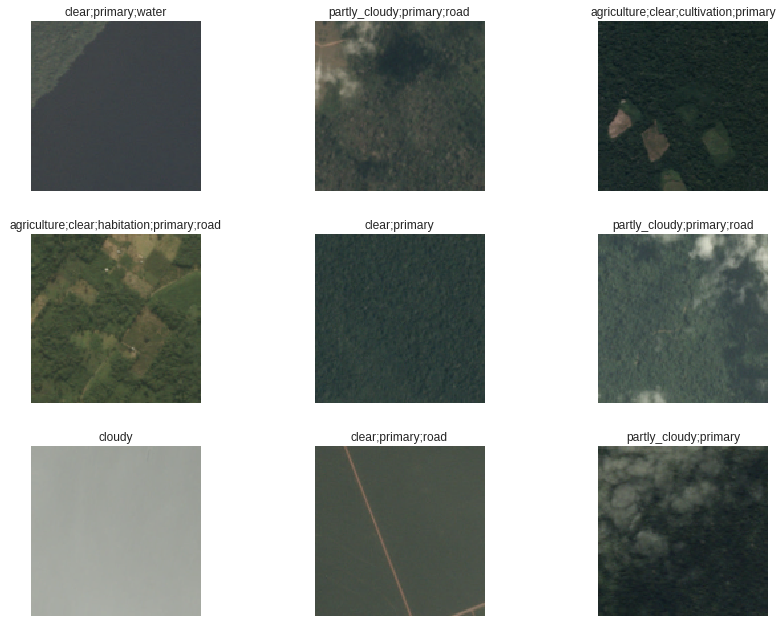

In [23]:
data.show_batch(rows=3, figsize=(12, 9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.5)

In [0]:
f_score = partial(fbeta, thresh=0.5)

In [70]:
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:93: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


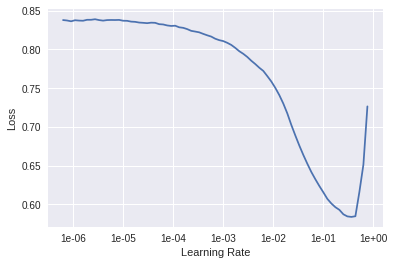

In [30]:
learn.recorder.plot()

In [0]:
lr = 0.1

In [32]:
learn.fit_one_cycle(5, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.163008,0.145780,0.949903,0.879236,03:35
1,0.172329,0.938563,0.943662,0.886171,03:33
2,0.140839,0.920320,0.952585,0.897610,03:33
3,0.109714,0.423072,0.957417,0.914267,03:32
4,0.098002,0.342447,0.956168,0.923500,03:35


In [0]:
learn.save("stage-1")

In [0]:
learn.unfreeze()

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


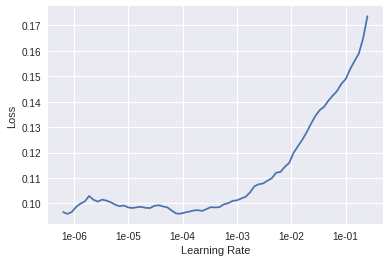

In [36]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, lr/5))

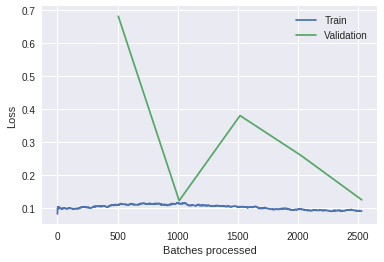

In [38]:
learn.recorder.plot_losses()

In [0]:
learn.save("stage-2")

In [0]:
learn.export()

In [56]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}
!7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99% 596M/603M [00:04<00:00, 86.3MB/s]
100% 603M/603M [00:05<00:00, 126MB/s] 


In [57]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}
!7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

test-jpg-additional.tar.7z: Skipping, found more recently modified local copy (use --force to force download)


In [58]:
test = ImageList.from_folder(path/"test-jpg").add(ImageList.from_folder(path/"test-jpg-additional"))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = ["".join([learn.data.classes[i] for i, p in enumerate(pred) if p > thresh]) for pred in preds]

In [61]:
labelled_preds[:5]

['agricultureclearcultivationprimary',
 'clearprimary',
 'clearprimary',
 'agricultureclearcultivationprimary',
 'clearprimary']

In [0]:
file_names = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({"image_name": file_names, "tags": labelled_preds}, columns=["image_name", "tags"])

In [0]:
df.to_csv(path/"submission.csv", index=False)

In [65]:
!kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/"submission.csv"} -m "My submission"

100% 2.07M/2.07M [00:14<00:00, 154kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space